<a href="https://colab.research.google.com/github/nishantruwari/projects/blob/main/comparing%20cnn%20architectures%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages (if not already installed)
!pip install torch torchvision matplotlib tqdm

# Check if GPU is available
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import necessary libraries
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Create directories if they don't exist
os.makedirs('coco/images', exist_ok=True)
os.makedirs('coco/annotations', exist_ok=True)

# Download a small COCO validation subset (images + annotations)
# Images (val2017 subset)
!wget -c http://images.cocodataset.org/zips/val2017.zip -P coco/images/
# Annotations (instances)
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/annotations/

# Unzip images and annotations
!unzip -q coco/images/val2017.zip -d coco/images/
!unzip -q coco/annotations/annotations_trainval2017.zip -d coco/annotations/

print("✅ Download and Extraction Done!")


--2025-04-30 10:02:21--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.119.41, 3.5.27.208, 52.217.112.201, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.119.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco/images/val2017.zip’

val2017.zip         100%[===================>] 777.80M  31.5MB/s    in 26s     

2025-04-30 10:02:46 (30.4 MB/s) - ‘coco/images/val2017.zip’ saved [815585330/815585330]

--2025-04-30 10:02:46--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.109.59, 52.217.116.153, 54.231.129.73, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.109.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco/annotations/annotati

In [3]:
# Define the root directories for images and annotations
coco_root = 'coco/images/val2017'
coco_ann_file = 'coco/annotations/annotations/instances_val2017.json'

# Basic transform: Resize images and convert to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for faster training
    transforms.ToTensor()
])

# Load the full COCO dataset (COCODetection expects image and annotations)
full_coco_dataset = CocoDetection(
    root=coco_root,
    annFile=coco_ann_file,
    transform=transform
)

# Now randomly sample a small subset (e.g., 500 images)
subset_size = 10000  # You can change this if you have more RAM
small_coco_dataset, _ = random_split(full_coco_dataset, [subset_size, len(full_coco_dataset) - subset_size])

# DataLoader
batch_size = 8  # Small batch size for Colab
train_loader = DataLoader(small_coco_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"✅ Small subset created with {len(train_loader.dataset)} images!")


loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
✅ Small subset created with 5000 images!


In [4]:
# Helper function to modify CNNs for segmentation
def get_segmentation_model(base_model_name, num_classes=91):  # COCO has 91 classes

    if base_model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Replace final layer
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif base_model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Sequential(
            nn.Linear(model.classifier[6].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif base_model_name == 'googlenet':
        model = models.googlenet(pretrained=True)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif base_model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Sequential(
            nn.Linear(model.classifier[6].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif base_model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    else:
        raise ValueError(f"Unsupported model: {base_model_name}")

    return model.to(device)

# Example: create one model
# model = get_segmentation_model('resnet50')
# print(model)  # Uncomment to view structure


In [5]:
# Define Cross Entropy Loss (good for multi-class segmentation)
criterion = nn.CrossEntropyLoss()

# Helper function to set optimizer for each model
def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr=lr)


In [6]:
def train_model(model, optimizer, num_epochs=10):
    model.train()
    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total_pixels = 0

        loop = tqdm(train_loader, leave=True)
        for images, targets in loop:
            # Stack list of images into a batch tensor
            images = torch.stack(images).to(device)

            # Simplified: use only first object's category_id for each image
            labels = []
            for target in targets:
                if len(target) > 0:
                    labels.append(target[0]['category_id'])
                else:
                    labels.append(0)  # default background class

            labels = torch.tensor(labels).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Stats
            running_loss += loss.item()
            preds = torch.argmax(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_pixels += labels.size(0)

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / total_pixels

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return history


In [7]:
# Define custom collate function
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

# Updated DataLoader using collate_fn
batch_size = 8

train_loader = DataLoader(
    small_coco_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn   # <--- FIX: Add this line
)

print(f"✅ DataLoader created with custom collate_fn, batch size {batch_size}")


✅ DataLoader created with custom collate_fn, batch size 8


In [8]:
# for images, targets in loop:
#     # images is a list => stack them to form a batch tensor
#     images = torch.stack(images).to(device)

#     # COCO returns multiple annotations per image; we will simply use the first annotation's category_id
#     labels = []
#     for target in targets:
#         if len(target) > 0:
#             labels.append(target[0]['category_id'])
#         else:
#             labels.append(0)  # background class if no object

#     labels = torch.tensor(labels).to(device)

#     # Zero the parameter gradients
#     optimizer.zero_grad()

#     # Forward
#     outputs = model(images)

#     loss = criterion(outputs, labels)

#     # Backward
#     loss.backward()
#     optimizer.step()

#     # Statistics
#     running_loss += loss.item()
#     preds = torch.argmax(outputs, 1)
#     running_corrects += torch.sum(preds == labels).item()
#     total_pixels += labels.size(0)

#     # Update tqdm
#     loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
#     loop.set_postfix(loss=loss.item())


In [9]:
# Define the models you want to train
model_names = ['resnet50', 'vgg16', 'googlenet', 'alexnet', 'mobilenet_v2']
histories = {}

# Loop through each model
for name in model_names:
    print(f"\n🚀 Training model: {name.upper()}")

    model = get_segmentation_model(name)
    optimizer = get_optimizer(model)

    history = train_model(model, optimizer, num_epochs=10)
    histories[name] = history

    # Free up GPU memory after training each model
    del model
    torch.cuda.empty_cache()

print("\n✅ All models trained and histories saved!")



🚀 Training model: RESNET50


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]
Epoch [1/10]: 100%|██████████| 625/625 [01:14<00:00,  8.38it/s, loss=3.55]


Epoch 1/10, Loss: 3.8024, Accuracy: 0.1880


Epoch [2/10]: 100%|██████████| 625/625 [01:16<00:00,  8.17it/s, loss=3]


Epoch 2/10, Loss: 3.7143, Accuracy: 0.1904


Epoch [3/10]: 100%|██████████| 625/625 [01:16<00:00,  8.18it/s, loss=4.24]


Epoch 3/10, Loss: 3.6999, Accuracy: 0.1908


Epoch [4/10]: 100%|██████████| 625/625 [01:15<00:00,  8.23it/s, loss=3.55]


Epoch 4/10, Loss: 3.6310, Accuracy: 0.1886


Epoch [5/10]: 100%|██████████| 625/625 [01:16<00:00,  8.19it/s, loss=4.4]


Epoch 5/10, Loss: 3.5958, Accuracy: 0.1896


Epoch [6/10]: 100%|██████████| 625/625 [01:16<00:00,  8.18it/s, loss=4.1]


Epoch 6/10, Loss: 3.5694, Accuracy: 0.1900


Epoch [7/10]: 100%|██████████| 625/625 [01:16<00:00,  8.19it/s, loss=2.99]


Epoch 7/10, Loss: 3.5272, Accuracy: 0.1912


Epoch [8/10]: 100%|██████████| 625/625 [01:16<00:00,  8.18it/s, loss=3.64]


Epoch 8/10, Loss: 3.5086, Accuracy: 0.1908


Epoch [9/10]: 100%|██████████| 625/625 [01:16<00:00,  8.20it/s, loss=3.4]


Epoch 9/10, Loss: 3.4986, Accuracy: 0.1914


Epoch [10/10]: 100%|██████████| 625/625 [01:16<00:00,  8.19it/s, loss=3.6]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10/10, Loss: 3.4554, Accuracy: 0.1906

🚀 Training model: VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]
Epoch [1/10]: 100%|██████████| 625/625 [02:17<00:00,  4.53it/s, loss=3.75]


Epoch 1/10, Loss: 3.8763, Accuracy: 0.1854


Epoch [2/10]: 100%|██████████| 625/625 [02:16<00:00,  4.57it/s, loss=3.73]


Epoch 2/10, Loss: 3.7478, Accuracy: 0.1904


Epoch [3/10]: 100%|██████████| 625/625 [02:17<00:00,  4.56it/s, loss=4.1]


Epoch 3/10, Loss: 3.7353, Accuracy: 0.1904


Epoch [4/10]: 100%|██████████| 625/625 [02:16<00:00,  4.56it/s, loss=4.08]


Epoch 4/10, Loss: 3.7335, Accuracy: 0.1904


Epoch [5/10]: 100%|██████████| 625/625 [02:16<00:00,  4.57it/s, loss=4.07]


Epoch 5/10, Loss: 4.1792, Accuracy: 0.1800


Epoch [6/10]: 100%|██████████| 625/625 [02:16<00:00,  4.59it/s, loss=4.16]


Epoch 6/10, Loss: 3.7371, Accuracy: 0.1904


Epoch [7/10]: 100%|██████████| 625/625 [02:16<00:00,  4.59it/s, loss=3.66]


Epoch 7/10, Loss: 3.7267, Accuracy: 0.1904


Epoch [8/10]: 100%|██████████| 625/625 [02:16<00:00,  4.59it/s, loss=3.16]


Epoch 8/10, Loss: 3.7188, Accuracy: 0.1904


Epoch [9/10]: 100%|██████████| 625/625 [02:16<00:00,  4.59it/s, loss=4.11]


Epoch 9/10, Loss: 3.7194, Accuracy: 0.1904


Epoch [10/10]: 100%|██████████| 625/625 [02:16<00:00,  4.59it/s, loss=3.51]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Epoch 10/10, Loss: 3.7147, Accuracy: 0.1904

🚀 Training model: GOOGLENET


100%|██████████| 49.7M/49.7M [00:00<00:00, 180MB/s]
Epoch [1/10]: 100%|██████████| 625/625 [00:50<00:00, 12.48it/s, loss=3.58]


Epoch 1/10, Loss: 3.6825, Accuracy: 0.1864


Epoch [2/10]: 100%|██████████| 625/625 [00:49<00:00, 12.63it/s, loss=2.96]


Epoch 2/10, Loss: 3.4658, Accuracy: 0.1966


Epoch [3/10]: 100%|██████████| 625/625 [00:49<00:00, 12.60it/s, loss=3.75]


Epoch 3/10, Loss: 3.3454, Accuracy: 0.2068


Epoch [4/10]: 100%|██████████| 625/625 [00:49<00:00, 12.51it/s, loss=3.6]


Epoch 4/10, Loss: 3.2833, Accuracy: 0.2164


Epoch [5/10]: 100%|██████████| 625/625 [00:50<00:00, 12.28it/s, loss=2.66]


Epoch 5/10, Loss: 3.2078, Accuracy: 0.2140


Epoch [6/10]: 100%|██████████| 625/625 [00:49<00:00, 12.56it/s, loss=3.54]


Epoch 6/10, Loss: 3.1448, Accuracy: 0.2216


Epoch [7/10]: 100%|██████████| 625/625 [00:49<00:00, 12.52it/s, loss=3.19]


Epoch 7/10, Loss: 3.0941, Accuracy: 0.2268


Epoch [8/10]: 100%|██████████| 625/625 [00:48<00:00, 12.76it/s, loss=3.49]


Epoch 8/10, Loss: 3.0577, Accuracy: 0.2318


Epoch [9/10]: 100%|██████████| 625/625 [00:49<00:00, 12.53it/s, loss=3.65]


Epoch 9/10, Loss: 3.0061, Accuracy: 0.2416


Epoch [10/10]: 100%|██████████| 625/625 [00:49<00:00, 12.57it/s, loss=2.97]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 10/10, Loss: 2.9723, Accuracy: 0.2464

🚀 Training model: ALEXNET


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 186MB/s]
Epoch [1/10]: 100%|██████████| 625/625 [00:42<00:00, 14.56it/s, loss=3.8]


Epoch 1/10, Loss: 3.7997, Accuracy: 0.1870


Epoch [2/10]: 100%|██████████| 625/625 [00:42<00:00, 14.82it/s, loss=4.58]


Epoch 2/10, Loss: 3.7373, Accuracy: 0.1904


Epoch [3/10]: 100%|██████████| 625/625 [00:42<00:00, 14.56it/s, loss=4.01]


Epoch 3/10, Loss: 3.7344, Accuracy: 0.1904


Epoch [4/10]: 100%|██████████| 625/625 [00:44<00:00, 14.19it/s, loss=3.57]


Epoch 4/10, Loss: 3.7273, Accuracy: 0.1904


Epoch [5/10]: 100%|██████████| 625/625 [00:43<00:00, 14.49it/s, loss=3.41]


Epoch 5/10, Loss: 3.7236, Accuracy: 0.1904


Epoch [6/10]: 100%|██████████| 625/625 [00:42<00:00, 14.77it/s, loss=3.16]


Epoch 6/10, Loss: 3.7210, Accuracy: 0.1904


Epoch [7/10]: 100%|██████████| 625/625 [00:42<00:00, 14.64it/s, loss=4.03]


Epoch 7/10, Loss: 3.7211, Accuracy: 0.1904


Epoch [8/10]: 100%|██████████| 625/625 [00:42<00:00, 14.71it/s, loss=3.27]


Epoch 8/10, Loss: 3.7186, Accuracy: 0.1904


Epoch [9/10]: 100%|██████████| 625/625 [00:41<00:00, 15.03it/s, loss=3.84]


Epoch 9/10, Loss: 3.7123, Accuracy: 0.1904


Epoch [10/10]: 100%|██████████| 625/625 [00:41<00:00, 14.98it/s, loss=3.69]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Epoch 10/10, Loss: 3.7136, Accuracy: 0.1904

🚀 Training model: MOBILENET_V2


100%|██████████| 13.6M/13.6M [00:00<00:00, 119MB/s] 
Epoch [1/10]: 100%|██████████| 625/625 [00:48<00:00, 12.81it/s, loss=3.21]


Epoch 1/10, Loss: 3.6987, Accuracy: 0.1862


Epoch [2/10]: 100%|██████████| 625/625 [00:49<00:00, 12.64it/s, loss=3.38]


Epoch 2/10, Loss: 3.4852, Accuracy: 0.1970


Epoch [3/10]: 100%|██████████| 625/625 [00:49<00:00, 12.51it/s, loss=3.99]


Epoch 3/10, Loss: 3.3771, Accuracy: 0.1992


Epoch [4/10]: 100%|██████████| 625/625 [00:49<00:00, 12.50it/s, loss=3.6]


Epoch 4/10, Loss: 3.3105, Accuracy: 0.2062


Epoch [5/10]: 100%|██████████| 625/625 [00:47<00:00, 13.21it/s, loss=2.76]


Epoch 5/10, Loss: 3.2703, Accuracy: 0.2052


Epoch [6/10]: 100%|██████████| 625/625 [00:48<00:00, 12.93it/s, loss=3.01]


Epoch 6/10, Loss: 3.2336, Accuracy: 0.2090


Epoch [7/10]: 100%|██████████| 625/625 [00:48<00:00, 12.94it/s, loss=2.85]


Epoch 7/10, Loss: 3.1846, Accuracy: 0.2160


Epoch [8/10]: 100%|██████████| 625/625 [00:48<00:00, 12.97it/s, loss=3.1]


Epoch 8/10, Loss: 3.1576, Accuracy: 0.2150


Epoch [9/10]: 100%|██████████| 625/625 [00:47<00:00, 13.25it/s, loss=3.09]


Epoch 9/10, Loss: 3.1039, Accuracy: 0.2238


Epoch [10/10]: 100%|██████████| 625/625 [00:48<00:00, 12.85it/s, loss=2.78]


Epoch 10/10, Loss: 3.0765, Accuracy: 0.2294

✅ All models trained and histories saved!


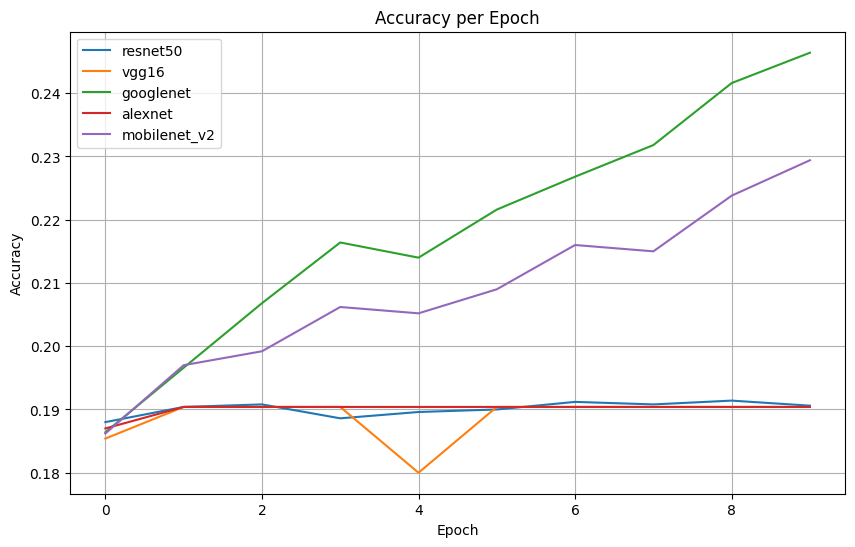

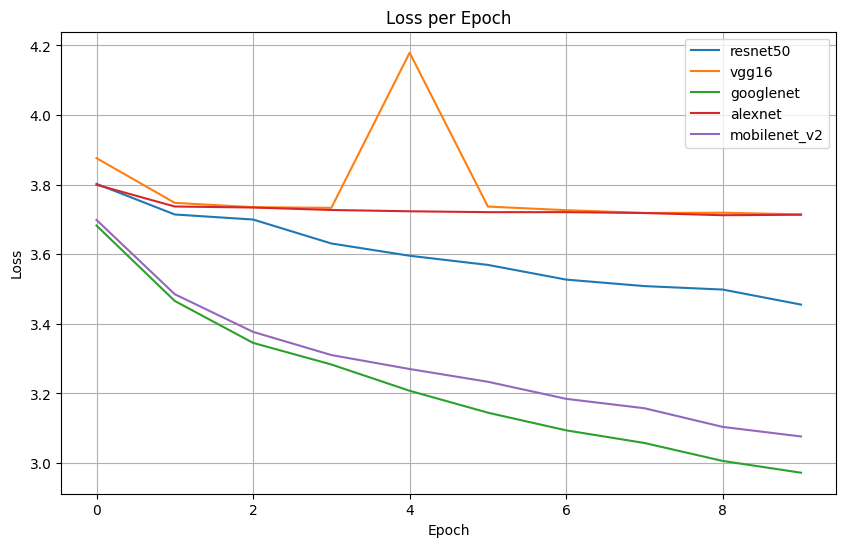

In [10]:
 # Plot Accuracy and Loss for all models
def plot_metric(metric_name, histories):
    plt.figure(figsize=(10, 6))
    for model_name, history in histories.items():
        plt.plot(history[metric_name], label=model_name)
    plt.title(f'{metric_name.capitalize()} per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Accuracy
plot_metric('accuracy', histories)

# Plot Loss
plot_metric('loss', histories)
